In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set()
%matplotlib inline

In [2]:
train = pd.read_csv('C:/Users/KIHyuk/Desktop/dacon_data/Kaggle_주택가격/train.csv')
test = pd.read_csv('C:/Users/KIHyuk/Desktop/dacon_data/Kaggle_주택가격/test.csv')
sample_submission = pd.read_csv('C:/Users/KIHyuk/Desktop/dacon_data/Kaggle_주택가격/sample_submission.csv')

In [3]:
train_copy = train.copy()

print(train.shape)

print("전체 피처의 type \n",train_copy.dtypes.value_counts())

isnull_series = train_copy.isnull().sum()
print("\nNull 컬럼과 그 건수 : \n",isnull_series[isnull_series > 0].sort_values(ascending=False))

(1460, 81)
전체 피처의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 컬럼과 그 건수 : 
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


In [4]:
train_copy.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


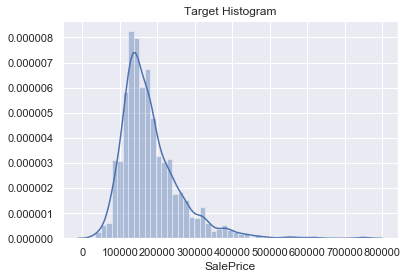

In [5]:
# target 분포 확인
plt.title("Target Histogram")
sns.distplot(train_copy['SalePrice'])

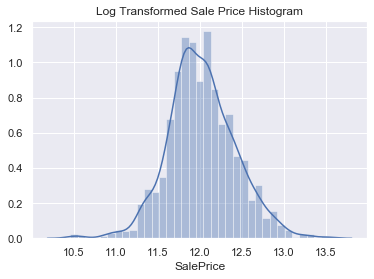

In [6]:
# 정규분포가 아닌 target값을 log변환 

plt.title("Log Transformed Sale Price Histogram")
log_target = np.log1p(train_copy['SalePrice'])
sns.distplot(log_target)

In [7]:
# null값 많은 컬럼 삭제
train_copy.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis=1,inplace=True)

# drop하지 않은 숫자형 컬럼의 Null값은 평균값으로 대체
train_copy.fillna(train_copy.mean(),inplace=True)

# target log변환 적용
train_copy['SalePrice'] = np.log1p(train_copy['SalePrice'])

In [8]:
# 문자형 피처 원-핫인코딩
# 문자형 피처 원-핫인코딩 변환 시 Null값은 자동으로 "None"컬럼으로 대체해줌.

train_copy_ohe = pd.get_dummies(train_copy) # 피처 수 75에서 271로 증가

In [9]:
# 평가함수
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test,pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__,'로그 변환된 RMSE:',np.round(rmse,3))
    return rmse

# 여러모델 넣을때
def get_rmses(models): 
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [15]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = train_copy_ohe['SalePrice']
X_features = train_copy_ohe.drop('SalePrice',axis=1)
X_train,X_test,y_train,y_test = train_test_split(X_features,y_target,test_size=0.2,random_state=156)

# LinearRegrssion,Ridge,Lasso 학습,예측,평가
lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train,y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train,y_train)

models = [lr_reg,ridge_reg,lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.13189576579154372, 0.12750846334053045, 0.17628250556471395]

In [ ]:
# 모델별 피처 회귀계수 

def get_top_bottom_coef(model,n=10):
    #coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개, - 하위 10개의 회귀계수를 추출해 반환
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high,coef_low